In [70]:
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
import itertools
import scipy.optimize as opt

class LinearEnvironment:
    """
    finite set of articles
    """
    def __init__(self, dim=10, numOfUsers=10, numOfArticles=10, er=0.5):
        self.dim = dim
        self.numOfUsers = numOfUsers
        self.numOfArticles = numOfArticles
        self.neighbors = [[] for i in range(numOfUsers)]
        for i in range(numOfUsers):
            for j in range(numOfUsers):
                if i==j or random.random() <= er:
                    self.neighbors[i].append(j)
        self.theta = []
        for i in range(numOfUsers):
            self.theta.append(np.array([random.random() for k in range(dim)]))
        self.context = []
        for j in range(numOfArticles):
            self.context.append(np.array([random.random() for k in range(dim)]))
            
    def reveal(self):
        return self.neighbors, self.context
    
    def feedback(self, user, article):
        return np.inner(self.theta[user], self.context[article]) + random.gauss(0, 0.1)
    
    def optimal_value(self, T):
        optValuePerStep = 0
        for user in range(self.numOfUsers):
            optValuePerStep += max([np.inner(self.theta[user], self.context[article]) for article in range(self.numOfArticles)])
        optimalValue = np.ones(T) * optValuePerStep
        return optimalValue
    
    def regret_per_action(self):
        Delta = []
        for user in range(self.numOfUsers):
            value = [np.inner(self.theta[user], self.context[article]) for article in range(self.numOfArticles)]
            optValue = max(value)
            Delta.append([optValue - value[article] for article in range(self.numOfArticles)])
        return Delta

In [74]:
def LinUCB(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    payoff = []
    decision = []
    for t in range(T):
        tmpPayoff = 0
        tmpDecision = []
        for user in range(numOfUsers):
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            ucb = []
            for x in context:
                p = np.dot(theta[user].transpose(),x.reshape(dim,1))  
                ucb.append(p+alpha*np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1))))
            action = np.argmax(ucb)
            rew = myEnvironment.feedback(user, action)
            matrixA[user] += np.dot(context[action].reshape(dim,1),context[action].reshape(1,dim))
            vectorB[user] += rew*context[action].reshape(dim,1)
            tmpPayoff += rew
            tmpDecision.append(action)
        payoff.append(tmpPayoff)
        decision.append(tmpDecision)
    return payoff, decision

def LinUCB_N(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    payoff = []
    decision = []
    action = [0 for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            ucb = []
            for x in context:
                p = np.dot(theta[user].transpose(),x.reshape(dim,1))  
                ucb.append(p+alpha*np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1))))
            action[user] = np.argmax(ucb)
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
        decision.append(copy.copy(action))
    return payoff, decision

In [181]:
def barycentric_spanner_index(S, delta):
    K = len(S)
    if K == 0:
        return
    d = len(S[0])
    if K < d:
        return
    res = random.sample(range(K), d)
    # print("barycentric_spanner: Looking for initial basis\n")
    while abs(np.linalg.det([S[i] for i in res])) <= 0:
        res = random.sample(range(K), d)
    # print("barycentric_spanner: Found initial basis\n")
    for i in range(d):
        det_value = []
        res_copy = copy.copy(res)
        for j in range(K):
            res_copy[i] = j
            det_value.append(abs(np.linalg.det([S[k] for k in res_copy])))
        i_max = np.argmax(det_value)
        res[i] = i_max
    # print("barycentric_spanner: Maximized each dimension\n")
    C = 1 + delta
    Terminate = False
    while not Terminate:
        Terminate = True
        tmp = abs(np.linalg.det([S[i] for i in res]))
        for i, j in itertools.product(range(d), range(K)):
            res_copy = copy.copy(res)
            res_copy[i] = j
            new_tmp = abs(np.linalg.det([S[k] for k in res_copy]))
            if new_tmp > C * tmp:
                res[i] = j
                tmp = new_tmp
                Terminate = False
    return res

def f_n_delta(n, delta, dim):
    c = 1
    return 2*(1+1/np.log(n))*np.log(1/delta) + c*dim*np.log(dim*np.log(n))

def f_n(n, dim):
    return 2*np.log(n) #f_n_delta(n, 1/n, dim)

def g_n(n, dim):
    return f_n_delta(n, 1/np.log(n), dim)

In [75]:
def oracle_obj(x, gap):
    return np.dot(x.transpose(),np.array(gap))

def oracle_constr(x, gap, T, dim, context):
    fn = f_n(T, dim)
    k = len(context)
    constr = []
    # constr.append(T - np.sum(x))
    gap_filter_index = [(i,g) for i,g in enumerate(gap) if g>0]
    gap_min = np.min(gap_filter_index,axis=0)[1]
    gap_max = np.max(gap_filter_index,axis=0)[1]
    constr.append(2*dim**3 * fn*gap_max/(gap_min**3) - np.sum([x[i] for i,g in gap_filter_index]))
    H = np.zeros((dim,dim))
    for i in range(k):
        H += x[i] * np.dot(context[i].reshape(dim,1),context[i].reshape(1,dim))
    H_inv = np.linalg.pinv(H)
    for i,g in gap_filter_index:
        constr.append(g*g/fn - np.dot(np.dot(context[i].reshape(1,dim),H_inv),context[i].reshape(dim,1))[0][0])
    return np.array(constr)
    
def oracle(gap, T, dim, context):
    k = len(context)
    # x_0 = np.ones(k)*T/k
    x_0 = [np.log(T) if g>0 else T for g in gap]
    bounds = [(0,None) for i in range(k)]
    cons = ({'type': 'ineq', 'fun': oracle_constr, 'args': (gap, T, dim, context)})
    res = opt.minimize(oracle_obj,x_0,args=(gap),bounds=bounds, constraints=cons)#, method='SLSQP')
    # check the sum = T with print if violating
    if np.sum(res.x) < T:
        opt_act = np.argmin(gap)
        adj_res = [res.x[i] for i in range(k)]
        adj_res[opt_act] += T - np.sum(res.x)
        # print("oracle output sum < T\n")
        return np.array(adj_res)
    else:
        return res.x/np.sum(res.x)*T
    
def Lattimore(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = [True for user in range(numOfUsers)]
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    decision = []
    bounds = [None for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        tmpDecision = []
        for user in range(numOfUsers):
            mu_prev = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
            if t < dim*np.ceil(np.sqrt(np.log(T))):
                action = spanner_B[t%dim]
            elif success[user]:
                epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
                largest = np.max(mu)
                gap = [largest - mean for mean in mu]
                if np.max([abs(mean - mean_prev) for mean, mean_prev in zip(mu,mu_prev)]) > 2 * epsilon:
                    success[user] = False
                else:
                    # play action according to the optimizer
                    if t == dim*np.ceil(np.sqrt(np.log(T))):
                        bounds[user] = oracle(gap, T, dim, context)
                        # print(bounds[user])
                    action = np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])])
            if not success[user]:
                action = np.argmax(np.array(mu) + np.array(confidence) * alpha)
            count[user][action] += 1
            rew = myEnvironment.feedback(user, action)
            matrixA[user] += np.dot(context[action].reshape(dim,1),context[action].reshape(1,dim))
            vectorB[user] += rew*context[action].reshape(dim,1)
            tmpPayoff += rew
            tmpDecision.append(action)
        payoff.append(tmpPayoff)
        decision.append(tmpDecision)
    # print(count)
    return payoff, decision

def Lattimore_N(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = [True for user in range(numOfUsers)]
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    decision = []
    bounds = [None for user in range(numOfUsers)]
    action = [0 for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            mu_prev = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
            if t < dim*np.ceil(np.sqrt(np.log(T))):
                action[user] = spanner_B[t%dim]
            elif success[user]:
                epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
                largest = np.max(mu)
                gap = [largest - mean for mean in mu]
                if np.max([abs(mean - mean_prev) for mean, mean_prev in zip(mu,mu_prev)]) > 2 * epsilon:
                    success[user] = False
                else:
                    # play action according to the optimizer
                    if t == dim*np.ceil(np.sqrt(np.log(T))):
                        bounds[user] = oracle(gap, T, dim, context)
                        # print(bounds[user])
                    action[user] = np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])])
            if not success[user]:
                action[user] = np.argmax(np.array(mu) + np.array(confidence) * alpha)
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                    count[user][article] += 1
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
        decision.append(copy.copy(action))
    # print(count)
    return payoff, decision

In [77]:
def oracle_obj_LP(x, gap):
    return np.dot(x.transpose(),np.array(gap).flatten())

def oracle_constr_LP(x, gap, T, dim, context, neighbors):
    fn = f_n(T, dim)
    k = len(context)
    numOfUsers = len(gap)
    constr = []
    plays = x.reshape(numOfUsers, k)
    H = [np.zeros((dim,dim)) for user in range(numOfUsers)]
    for user in range(numOfUsers):
        for article in range(k):
            for neigh in neighbors[user]:
                H[neigh] += plays[user][article] * np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
    H_inv = [np.linalg.pinv(H[user]) for user in range(numOfUsers)]
    for user in range(numOfUsers):
        for article in range(k):
            if gap[user][article] > 0:
                constr.append(gap[user][article]*gap[user][article]/fn - np.dot(np.dot(context[article].reshape(1,dim),H_inv[user]),context[article].reshape(dim,1))[0][0])
    return np.array(constr)
    
def oracle_LP(gap, T, dim, context, neighbors):
    k = len(context)
    numOfUsers = len(gap)
    # x_0 = np.ones(k*numOfUsers)*T/k
    x_0 = [np.log(T) if g>0 else T for g in np.array(gap).flatten()]
    bounds = [(0,None) for i in range(k*numOfUsers)]
    cons = ({'type': 'ineq', 'fun': oracle_constr_LP, 'args': (gap, T, dim, context, neighbors)})
    res = opt.minimize(oracle_obj_LP,x_0,args=(gap),bounds=bounds, constraints=cons)#, method='SLSQP')
    bounds = res.x.reshape(numOfUsers, k)
    for user in range(numOfUsers):
        if np.sum(bounds[user]) < T:
            adj = T - np.sum(bounds[user])
            opt_act = np.argmin(gap[user])
            bounds[user][opt_act] += adj
        else:
            bounds[user] = bounds[user]/np.sum(bounds[user]) * T
    # print("LP value:{}".format(oracle_obj_LP(bounds.flatten(),gap)))
    return bounds

def Optimal_LP(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context):
    barycentric_tolerance = 0.1
    spanner_B = barycentric_spanner_index(context, barycentric_tolerance)
    alpha = 1 + np.sqrt(np.log(2*T)/2)
    matrixA = [np.identity(dim) for user in range(numOfUsers)]
    vectorB = [np.zeros((dim,1)) for user in range(numOfUsers)]
    theta = [np.zeros((dim,1)) for user in range(numOfUsers)]
    success = True
    count = [np.zeros((numOfArticles,1)) for user in range(numOfUsers)]
    payoff = []
    decision = []
    bounds = [None for user in range(numOfUsers)]
    action = [0 for user in range(numOfUsers)]
    mu_prev = [[] for user in range(numOfUsers)]
    mu = [[] for user in range(numOfUsers)]
    confidence = [[] for user in range(numOfUsers)]
    gap = [[] for user in range(numOfUsers)]
    for t in range(T):
        tmpPayoff = 0
        for user in range(numOfUsers):
            mu_prev[user] = [np.inner(theta[user].reshape(dim,),x) for x in context]
            matrixA_inv = np.linalg.inv(matrixA[user])
            theta[user] = np.dot(matrixA_inv,vectorB[user])
            mu[user] = [np.inner(theta[user].reshape(dim,),x) for x in context]
            confidence[user] = [np.sqrt(np.dot(np.dot(x.reshape(1,dim),matrixA_inv),x.reshape(dim,1)))[0][0] for x in context]
        
        if t < dim*np.ceil(np.log(T)):#dim*np.ceil(np.sqrt(np.log(T))):
            action = [spanner_B[t%dim] for user in range(numOfUsers)]
        elif success:
            epsilon = np.max(confidence) * np.sqrt(g_n(T,dim))
            largest = np.max(mu, axis=1)
            gap = [[largest[user] - mean for mean in mu[user]] for user in range(numOfUsers)]
            
            if np.max([[abs(mean - mean_prev) for mean, mean_prev in zip(mu[user],mu_prev[user])] for user in range(numOfUsers)]) > 2 * epsilon:
                success = False
            else:
                if t == dim*np.ceil(np.log(T)) or t%(dim*np.ceil(np.log(T))*numOfUsers*numOfArticles) == 0:#dim*np.ceil(np.sqrt(np.log(T))):
                    bounds = oracle_LP(gap, T, dim, context, neighbors)
                action = [np.random.choice([i for i in range(numOfArticles) if count[user][i] <= np.ceil(bounds[user][i])]) for user in range(numOfUsers)]
        if not success:
            action = [np.argmax(np.array(mu[user]) + np.array(confidence[user]) * alpha) for user in range(numOfUsers)]
        for user in range(numOfUsers):
            article = action[user]
            for neigh in neighbors[user]:
                rew = myEnvironment.feedback(neigh, article)
                if neigh == user:
                    tmpPayoff += rew
                    count[user][article] += 1
                matrixA[neigh] += np.dot(context[article].reshape(dim,1),context[article].reshape(1,dim))
                vectorB[neigh] += rew*context[article].reshape(dim,1)
        payoff.append(tmpPayoff)
        decision.append(copy.copy(action))
    return payoff, decision

In [154]:
def testbed(bandit_list,
            T = 10000,
            dim=2,
            numOfUsers=2,
            numOfArticles=5,
            er=1,
            repeat=1,
            display_dist=1,
            display_On=False
           ):
    myEnvironment = LinearEnvironment(dim=dim, numOfUsers=numOfUsers, numOfArticles=numOfArticles, er=er)
    neighbors, context = myEnvironment.reveal()
    #optPayoff = myEnvironment.optimal_value(T)
    delta = myEnvironment.regret_per_action()
    plt_sample = range(1,T+1,int(T/20))
    
    # run experiments
    for bandit in bandit_list:
        print(f'running {bandit}')
        #avg_regret = [0 for t in range(T)]
        pseudo_regret = [0 for t in range(T)]
        for run in range(repeat):
            if run%display_dist == 0 and display_On: 
                print('running round '+str(run)+'\n')
            payoff, decision = bandit(myEnvironment, T, dim, numOfUsers, numOfArticles, neighbors, context)
            for t in range(T):
                #avg_regret[t] += (optPayoff[t] - payoff[t])/repeat
                pseudo_regret[t] += sum([delta[user][decision[t][user]] for user in range(numOfUsers)])/repeat
        #cum_regret = [avg_regret[0]]
        pseudo_cum_regret = [pseudo_regret[0]]
        for t in range(1,T):
            #cum_regret.append(cum_regret[-1]+avg_regret[t])
            pseudo_cum_regret.append(pseudo_cum_regret[-1]+pseudo_regret[t])
        #plt.semilogx(cum_regret)
        #plt.show()
        plt.plot(plt_sample,[pseudo_cum_regret[i-1] for i in plt_sample], mark_up(bandit), label=label(bandit))
    plt.legend(fontsize=12)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Average regret', fontsize=15)
    plt.savefig(f'dim_{dim}_numOfUsers_{numOfUsers}_numOfArticles_{numOfArticles}_er_{er}.pdf')
    plt.show()

In [153]:
def label(bandit):
    label_map = {LinUCB:'LinUCB', LinUCB_N: 'LinUCB-N',Lattimore: 'Lattimore',Lattimore_N:'Lattimore-N',Optimal_LP:'Optimal-LP'}
    return label_map[bandit]

def mark_up(bandit):
    line = {LinUCB: 'y-', LinUCB_N: 'p--', Lattimore: 'g^-', Lattimore_N: 'bs-', Optimal_LP: 'r'}
    return line[bandit]

def testplot(bandit_list):
    counter = 1
    T = 1000
    #plt_sample = range(1,T+1,100)
    plt_sample = np.logspace(1,np.log(T),num=10,base=2)
    plt_sample = [int(np.ceil(i)) for i in plt_sample]
    for bandit in bandit_list:
        data = np.array(range(T))*counter
        plt.plot(plt_sample,[data[i-1] for i in plt_sample],mark_up(bandit),label=label(bandit))
        counter += 1
    plt.legend(fontsize=12)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Average regret', fontsize=15)
    plt.savefig('test.pdf')
    plt.show()

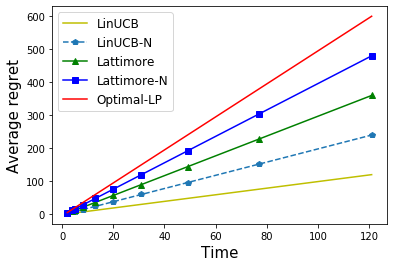

In [152]:
testplot([LinUCB,LinUCB_N,Lattimore,Lattimore_N,Optimal_LP])

running <function LinUCB at 0x00000221AD4100D8>
running <function LinUCB_N at 0x00000221AD410CA8>
running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


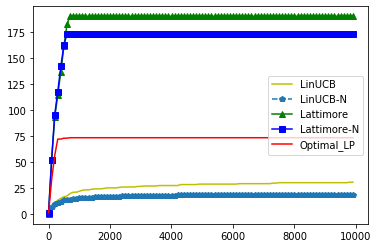

In [107]:
testbed([LinUCB,LinUCB_N,Lattimore,Lattimore_N,Optimal_LP], repeat = 1)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


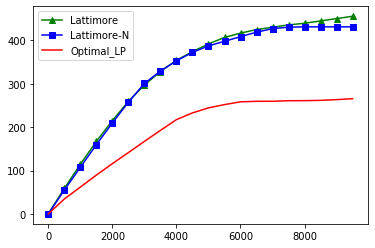

In [121]:
testbed([Lattimore,Lattimore_N,Optimal_LP], repeat = 10)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


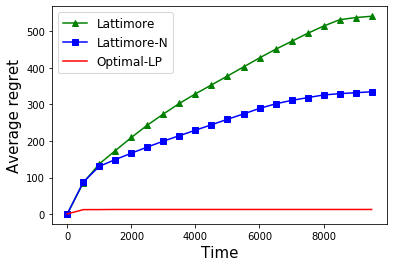

In [155]:
testbed([Lattimore,Lattimore_N,Optimal_LP], repeat = 10)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


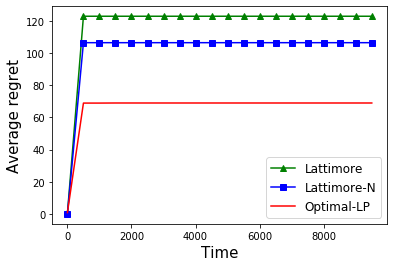

In [159]:
testbed([Lattimore,Lattimore_N,Optimal_LP], repeat = 10)

running <function LinUCB at 0x00000221AD4100D8>
running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


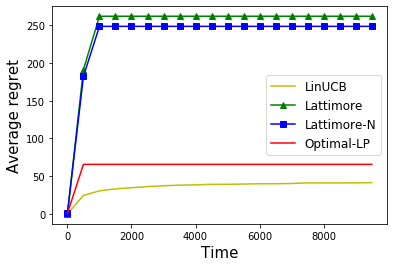

In [185]:
testbed([LinUCB, Lattimore,Lattimore_N,Optimal_LP], repeat = 1)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


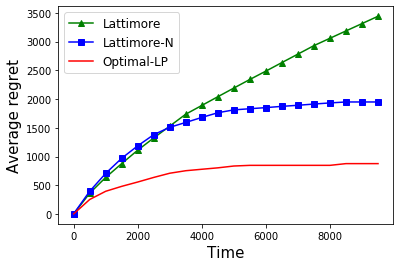

In [160]:
testbed([Lattimore,Lattimore_N,Optimal_LP], dim = 4, numOfUsers = 4, numOfArticles = 10, er = 0.5, repeat = 1)

running <function LinUCB at 0x00000221AD4100D8>
running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


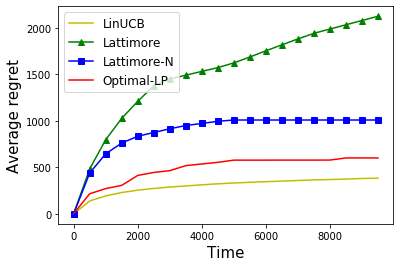

In [187]:
testbed([LinUCB, Lattimore,Lattimore_N,Optimal_LP], dim = 4, numOfUsers = 4, numOfArticles = 10, er = 0.5, repeat = 1)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


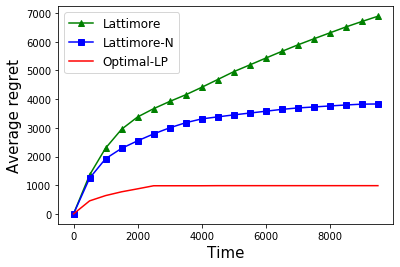

In [171]:
testbed([Lattimore,Lattimore_N,Optimal_LP], dim = 4, numOfUsers = 10, numOfArticles = 5, er = 0.5, repeat = 1)

running <function Lattimore at 0x00000221ABA041F8>
running <function Lattimore_N at 0x00000221ABA04B88>
running <function Optimal_LP at 0x00000221AC2DEF78>


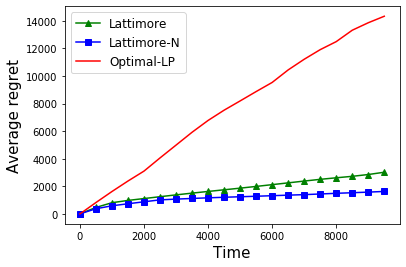

In [180]:
testbed([Lattimore,Lattimore_N,Optimal_LP], dim = 2, numOfUsers = 10, numOfArticles = 10, er = 0.5, repeat = 1)

In [54]:
testbed([LinUCB,Lattimore,Optimal_LP], T=1000000, display_On=False)

running <function LinUCB at 0x00000221AB8D9C18>


KeyboardInterrupt: 

running <function LinUCB at 0x00000221AB8D9C18>


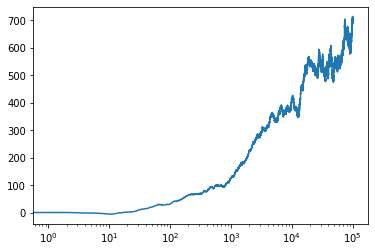

running <function Lattimore at 0x00000221AB8F4DC8>


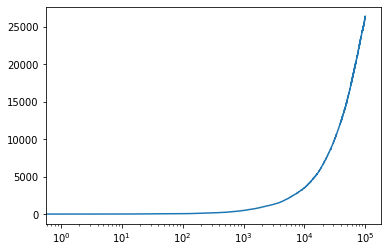

running <function Optimal_LP at 0x00000221AB938E58>


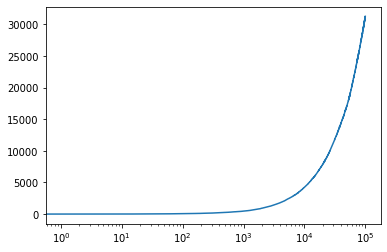

In [14]:
testbed([LinUCB,Lattimore,Optimal_LP], T=100000, numOfUsers=5, numOfArticles=5, display_On=False)

In [71]:
decision = []
for t in range(10):
    tmpDecision = []
    for user in range(4):
        tmpDecision.append(user+t*10)
    decision.append(tmpDecision)
decision

[[0, 1, 2, 3],
 [10, 11, 12, 13],
 [20, 21, 22, 23],
 [30, 31, 32, 33],
 [40, 41, 42, 43],
 [50, 51, 52, 53],
 [60, 61, 62, 63],
 [70, 71, 72, 73],
 [80, 81, 82, 83],
 [90, 91, 92, 93]]

In [73]:
decision = []
action = [0 for user in range(4)]
for t in range(10):
    for user in range(4):
        action[user] = user+t*10
    decision.append(copy.copy(action))
decision

[[0, 1, 2, 3],
 [10, 11, 12, 13],
 [20, 21, 22, 23],
 [30, 31, 32, 33],
 [40, 41, 42, 43],
 [50, 51, 52, 53],
 [60, 61, 62, 63],
 [70, 71, 72, 73],
 [80, 81, 82, 83],
 [90, 91, 92, 93]]